In [19]:
import cv2 as cv

from matplotlib import pyplot as plt
import networkx as nx
import itertools
import numpy as np
import math

In [20]:
def reduce_points(points,thresh):
    for point in points:
        if((point!=0).all()):
            dist = np.sum(np.square(points-point),axis=1)
            points[np.logical_and(dist>0,dist<thresh)]=0
            
    points = points.tolist()
    points = [i for i in points if i!=[0,0]]
    return np.array(points)

In [21]:
nonoise_vid = cv.VideoCapture('./1tagvideo.mp4')
if (nonoise_vid.isOpened() == False):
	print("Error opening the video file")
else:
  # Get frame rate information

  fps = int(nonoise_vid.get(5))
  print("Frame Rate : ",fps,"frames per second")	

  # Get frame count
  frame_count = nonoise_vid.get(7)
  print("Frame count : ", frame_count)


Frame Rate :  26 frames per second
Frame count :  787.0


In [22]:
frames = []
while(nonoise_vid.isOpened()):
	# nonoise_vid.read() methods returns a tuple, first element is a bool 
	# and the second is frame
  ret, frame = nonoise_vid.read()
  if ret == True:
    #Split the channels and invert color of the frame as we are only interested in the red channel
    frames.append(frame)
    break
  else:
    break

### Converting image into frequency domain

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x7f21c43ffdd0>)

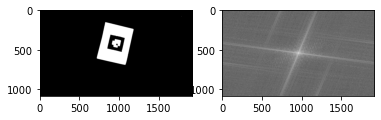

In [5]:
img1 = frames[0]
gray1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
gray1 = cv.medianBlur(gray1,5) ## Remove noise

sharpen = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
gray1 = cv.filter2D(gray1,-1,sharpen) ##Sharpen the image to get the edges more promanent 

gray1 = np.float32(gray1>160) ## Threshold the image


##perform FFT 
f= np.fft.fft2(gray1)
f = np.fft.fftshift(f)
magnitude = 20*np.log(np.abs(f))

plt.subplot(2,2,1),plt.imshow(gray1,"gray")
plt.subplot(2,2,2),plt.imshow(magnitude,"gray")

### Making a bandpass filter

In [6]:
rows, cols = gray1.shape
crow, ccol = int(rows/2), int(cols/2)       ##Center Pixel
mask = np.zeros((rows, cols), np.uint8)     ##Create a mask that is the same size as that of the image
size1 = 200
size2 = 500
x, y = np.ogrid[:rows, :cols]
bandpass_filter = np.logical_and(((x - crow) ** 2 + (y - ccol) ** 2 >= size1 ** 2),
                           ((x - crow) ** 2 + (y - ccol) ** 2 <= size2 ** 2))       ## Generate the region of the mask that needs to be populated with ones
mask[bandpass_filter] = 1   ##Populate the image with 

### Inverse FFT

/home/eurus/anaconda3/envs/enpm673_homework1/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x7f21c4239fd0>)

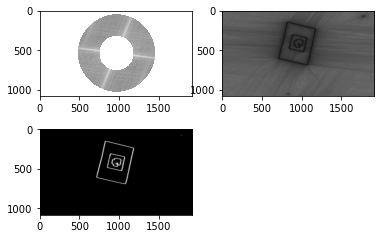

In [7]:
## Apply the mask to the FFT
iff_img = f*mask
ifft_mag = 20*np.log(np.abs(iff_img))   ##Masked FFT magnitude

iff_img = np.fft.ifftshift(iff_img)         
iff_img = np.fft.ifft2(iff_img)     ##Perform the inverse FFT


magnitude = -np.log(np.abs(iff_img))    ##Scale the magnitude of the image
magnitude *= (255.0/magnitude.max())    ##Normalize the image
magnitude_thre = np.float32(np.abs(magnitude-255)>220)  #Threshold and invert the image


plt.subplot(2,2,1),plt.imshow(ifft_mag,"gray")  ##Masked FFT 
plt.subplot(2,2,2),plt.imshow(magnitude,"gray") ##Magnitude of Masked IFFT
plt.subplot(2,2,3),plt.imshow(np.float32(magnitude_thre),"gray")    ##Threshold and inverted Image

### Marker detector

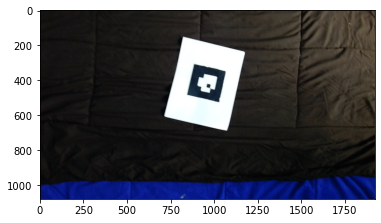

In [5]:
sharpen = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])

for imgs in frames:
    img = cv.medianBlur(imgs, 5)
    img = cv.filter2D(img,-1,sharpen) ##Sharpen the image to get the edges more promanent 
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    # gray = cv.threshold(gray,200,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    
    
    dx,dy = cv.spatialGradient(np.uint8(gray))
    G = np.hypot(dx, dy)
    G = G / G.max() * 255
    G = np.float32(G>100)
    theta = np.arctan2(dx, dy)
    
    break
plt.imshow(img)

# SCRATHPAD

In [23]:
sharpen = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
img = frames[0]
img = cv.medianBlur(img, 5)
img = cv.filter2D(img,-1,sharpen) ##Sharpen the image to get the edges more promanent 
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
corners = cv.goodFeaturesToTrack(gray,25,0.01,10)
corners = np.int0(corners)
list_of_corners = []
for i in corners:
    x,y = i.ravel()
    list_of_corners.append(np.array([x,y]))
    cv.circle(img, (x,y), 3, 255, -1)

In [24]:
cv.imshow("image",img)
cv.waitKey()
cv.destroyAllWindows()

In [25]:
list_of_point_pairs = []
for point_pairs in itertools.combinations(list_of_corners,2):
    p1,p2= point_pairs[0],point_pairs[1]
    dist = np.linalg.norm(p1-p2)
    if(dist>250):
        slope = (p2[1]-p1[1])/(p2[0]-p1[0])
        center =  np.array([(p1[0]+p2[0])/2,(p1[1]+p2[1])/2])
        list_of_point_pairs.append([p1,p2,slope,center,dist])

In [26]:
array_of_corners = np.array(list_of_point_pairs,dtype=object)
sort_idx = np.argsort(array_of_corners[:,-1])
array_of_corners = array_of_corners[sort_idx]
array_of_corners = array_of_corners[::-1]

In [27]:
list_of_rectangles = []
max_number = math.factorial(array_of_corners.shape[0])/(math.factorial(4)*(math.factorial(array_of_corners.shape[0]-4)))
for line in array_of_corners[::-1]:
    if len(list_of_rectangles) > 0.00001:
        break
    same_dist = (np.abs(array_of_corners[:,-1]-line[-1])<20)
    if not same_dist.any():
        continue
    pass
    similar_lines = array_of_corners[same_dist]
    similar_lines = similar_lines[np.where(similar_lines[:,2]!=line[2])]
    if not similar_lines.size:
        continue
    same_centers = np.linalg.norm(similar_lines[:,3][0]-line[3])<20
    if not same_centers.any():
        continue
    similar_center = similar_lines[same_centers]
    for c in similar_center[0]:
        list_of_rectangles.append([line[0].tolist(),c[0].tolist(),line[1].tolist(),c[1].tolist()])

In [28]:
list_of_rectangles = []
arr = np.delete(array_of_corners,(np.where(array_of_corners[:,-1]>500)),axis=0)
max_number = math.factorial(arr.shape[0])/(math.factorial(4)*(math.factorial(arr.shape[0]-4)))
for i,n in enumerate(arr):
    for j,m in enumerate(arr[i:-1]):
        if((n[0]==m[0]).all() or (n[1]==m[1]).all()):
            continue

        if(np.abs(n[-1]-m[-1])>20):
            continue
        if (np.linalg.norm(m[3]-n[3])>5):
            continue
        list_of_rectangles.append(np.array([n[0].tolist(),m[0].tolist(),n[1].tolist(),m[1].tolist()]))
        if(len(list_of_rectangles)>0.00001*max_number):
            break

In [16]:
len(list_of_rectangles)

3

In [17]:
for i in list_of_rectangles:
    pts = np.array(i, np.int32)
    pts = pts.reshape((-1,1,2))
    img_rect = cv.polylines(img,[pts],True,(0,255,255))


In [33]:
pts = np.array(list_of_rectangles[2], np.int32)
pts = pts.reshape((-1,1,2))
img_rect = cv.polylines(img,[pts],True,(0,255,255))

In [34]:
cv.imshow("image",img_rect)
cv.waitKey()
cv.destroyAllWindows()

In [49]:
len(list_of_rectangles)

99

In [13]:
list_of_rectangles[0]

array([[1023,  524],
       [ 821,  152],
       [ 821,  152],
       [1032,  494]])

In [38]:
list_of_point_pairs[:,1]==[0,0]

TypeError: list indices must be integers or slices, not tuple